In [1]:
! pip install EMD-signal

     ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
     ------------------- ------------------ 41.0/78.5 kB 991.0 kB/s eta 0:00:01
     ---------------------------------------- 78.5/78.5 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/74.6 kB ? eta -:--:--
   ---------------------------------------- 74.6/74.6 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/82.1 kB ? eta -:--:--
   ---------------------------------------- 82.1/82.1 kB 4.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/116.3 kB ? eta -:--:--
   ---------------------------------------- 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/133.4 kB ? eta -:--:--
   ---------------------------------------- 133.4/133.4 kB 7.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.8 kB ? eta -:--:--
   ---------------------------------------- 56.8/56.8 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import svm

from scipy import stats
from math import sqrt
from scipy.stats import norm
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from PyEMD import EMD

In [4]:
data = pd.read_csv("MDA8.csv")
# # Convert 'Date' column to datetime format
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, '%d-%m-%y'))
dates = data['Date'].copy() # to be used in further plots

# Sort the dataset by 'Date' in ascending order
data = data.sort_values('Date')
data = data.set_index('Date')

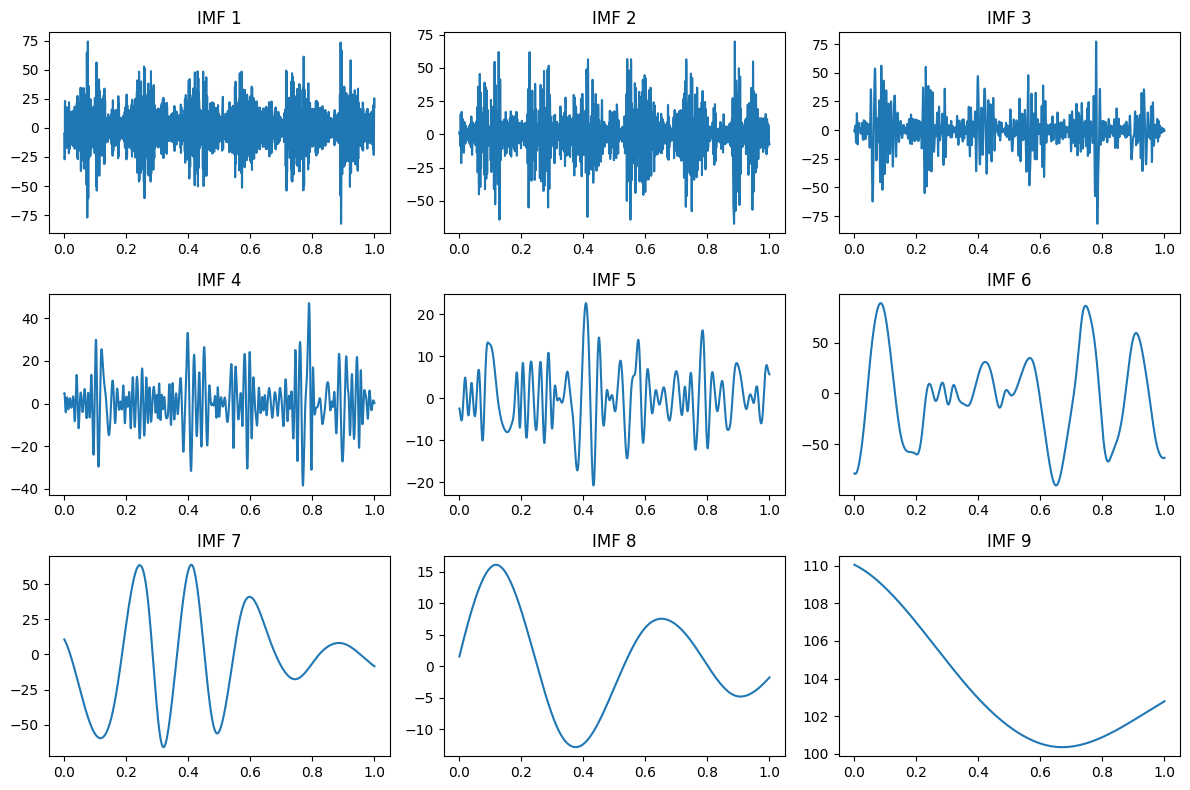

In [5]:
target = data['MDA8'].values
# Configurando a EMD
emd = EMD()

# Decomposição da série temporal em IMFs
IMFs = emd(target)
t = np.linspace(0, 1, target.size)


# Plotando as IMFs em uma matriz 3x3 de subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    if i < len(IMFs):
        ax.plot(t, IMFs[i])
        ax.set_title(f'IMF {i+1}')

# Remova quaisquer subplots não utilizados
for i in range(len(IMFs), len(axes.flat)):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [6]:
IMFs.shape

(9, 2192)

In [7]:
imfs = {"IMF 0": IMFs[0],"IMF 1": IMFs[1],"IMF 2": IMFs[2],"IMF 3": IMFs[3],"IMF 4": IMFs[4],"IMF 5": IMFs[5],"IMF 6": IMFs[6],"IMF 7": IMFs[7],"IMF 8": IMFs[8]}
df = pd.DataFrame(imfs)

In [8]:
df

,IMF 0,IMF 1,IMF 2,IMF 3,IMF 4,IMF 5,IMF 6,IMF 7,IMF 8
0,-5.000786,1.548205,0.066882,4.828755,-2.469337,-78.630596,10.714423,1.575450,110.047003
1,-5.719820,0.137133,-1.198941,4.935088,-2.591230,-78.773720,10.521148,1.666993,110.043349
2,-27.005755,-0.253022,-1.805281,4.455960,-2.753674,-78.890893,10.324569,1.758421,110.039673
3,-23.834123,1.040049,-1.307434,3.422875,-2.949954,-78.981796,10.124673,1.849733,110.035978
4,21.556267,1.682480,0.201300,2.004179,-3.172749,-79.046108,9.921442,1.940926,110.032261
...,...,...,...,...,...,...,...,...,...
2187,-13.735314,-4.355587,0.873651,1.115463,5.903714,-63.502628,-8.099917,-1.842479,102.773095
2188,-2.572671,-5.790328,0.589945,0.904764,5.833504,-63.464941,-8.170069,-1.817750,102.777546
2189,23.000385,-6.336469,0.192573,0.673351,5.776603,-63.415743,-8.239725,-1.792969,102.781994
2190,25.465954,-6.717153,-0.278057,0.432181,5.732563,-63.354905,-8.308886,-1.768134,102.786438


In [9]:
## Now create an input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
## Now create an GRU Model
def create_gru(units, X_train):
    model = Sequential()

    # Input layer
    model.add(GRU (units = units, return_sequences = True,
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))

    # Hidden layer
    model.add(GRU(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))

    #Compile model
    model.compile(optimizer= "adam", loss="mse")
    return model

def fit_model(model, X_train, y_train, batch_size=32):
  early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience = 20)
  model.fit(X_train, y_train, epochs = 200,
                      validation_split = 0.1,
                      batch_size = batch_size, shuffle = True,
                      callbacks = [early_stop])
  return model

def evaluation(test, predicted):
    # Calculating and printing the R2 value
    r2 = r2_score(test, predicted)
    print("R2 Value of sequential model:", round(r2, 3))

    # Calculating and printing the MAE score
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error:", round(mae, 2))

    # Calculating and printing the MSE score
    mse = mean_squared_error(test, predicted)
    print("Mean Squared Error:", round(mse, 2))

In [10]:
def create_model(data, batch_size):
  # Separação de dados de treinamento e de teste
  training_size = int(len(data)*0.84)  ## ~1 year as Training | change for exact training dataset
  train_data = data[:training_size]
  test_data = data[training_size:]
  # Normalização
  scaler = MinMaxScaler().fit(train_data)
  train_scaled = scaler.transform(train_data)
  test_scaled = scaler.transform(test_data)
  # Criação de dataset
  LOOK_BACK = 7 # Correct according to model / hypertuning
  X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
  X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
  print('X_train.shape:', X_train.shape)
  print('y_train.shape:', y_train.shape)
  print('X_test.shape:', X_test.shape)
  print('y_test.shape:', y_test.shape)
  #Criação e treinamento
  model = create_gru(128, X_train)
  model.summary()
  model = fit_model(model, X_train, y_train, batch_size)
  #Avaliação
  y_test = scaler.inverse_transform(y_test)
  prediction = model.predict(X_test)
  prediction = scaler.inverse_transform(prediction)
  evaluation(y_test, prediction)
  return model, X_test, y_test, X_train, y_train, scaler

In [11]:
model_list = []
X_test_list = []
y_test_list = []
X_train_list = []
y_train_list = []
scaler_list = []
for i in range(IMFs.shape[0]):

  model, X_test, y_test, X_train, y_train, scaler = create_model(df["IMF "+str(i)].values.reshape(-1,1),32)
  model_list.append(model)
  X_test_list.append(X_test)
  y_test_list.append(y_test)
  X_train_list.append(X_train)
  y_train_list.append(y_train)
  scaler_list.append(scaler)

X_train.shape: (1834, 7, 1)
y_train.shape: (1834, 1)
X_test.shape: (344, 7, 1)
y_test.shape: (344, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 128)            50304     
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 149505 (584.00 KB)
Trainable params: 149505 (584.00 KB)
Non-trainable pa

In [12]:
def predict_model(model, X_test, scaler):
  prediction = model.predict(X_test)
  prediction = scaler.inverse_transform(prediction)
  return prediction


In [13]:
prediction = np.zeros((len(model_list),y_test_list[0].shape[0]))
for i in range(len(model_list)):
  prediction[i] = predict_model(model_list[i], X_test_list[i], scaler_list[i]).flatten()

11/11 [==============================] - 0s 4ms/step


In [14]:
final = np.zeros(y_test_list[0].shape[0])
for i in range(y_test_list[0].shape[0]):
  final[i] = np.sum(prediction[:,i])

In [15]:
## Now create an input dataset
def create_windows (X, look_back = 1):
    Xs, ys = [], []

    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)

def serie_2dataset(serie):
  # Separação de dados de treinamento e de teste
  training_size = int(len(data)*0.84)  ## ~1 year as Training | change for exact training dataset
  train_data = data[:training_size]
  test_data = data[training_size:]
  # Normalização
  scaler = MinMaxScaler().fit(train_data)
  train_scaled = scaler.transform(train_data)
  test_scaled = scaler.transform(test_data)
  # Criação de janelas
  LOOK_BACK = 7 # Correct according to model / hypertuning
  X_train, y_train = create_windows(train_scaled,LOOK_BACK)
  X_test, y_test = create_windows(test_scaled,LOOK_BACK)
  return (X_train, y_train), (X_test, y_test), scaler

In [16]:
target = data['MDA8'].values #np.array

(X_train_simple, y_train_simple), (X_test_simple, y_test_simple), scaler_simple = serie_2dataset(target) # Simple dataset

In [17]:
y_test_simple_new = scaler_simple.inverse_transform(y_test_simple)

In [18]:
evaluation(y_test_simple_new, final)

R2 Value of sequential model: 0.89
Mean Absolute Error: 12.45
Mean Squared Error: 293.9


In [19]:
## ---- Model Plot ---- ##

def plot_vs_future_CI(y_test, model_name, prediction):
    mae = mean_absolute_error(y_test, prediction)
    dates_subset = dates[-y_test.shape[0]:]

    plt.figure(figsize=(10, 5), dpi=100)
    range_future = len(prediction)

    # Define colors for the plot
    test_color = 'steelblue' #can cahnge color in future if required
    pred_color = 'k'

    plt.plot(dates_subset, y_test, color=test_color, label="Test data") #linestyle='dashed'
    plt.plot(dates_subset, prediction, color=pred_color, label="Predictions")

    plt.title("Test data vs prediction for " + model_name)
    plt.legend(loc="upper right")

    offset1 = 55
    plt.annotate('R$^2$ = {:.3f}'.format(r2_score(y_test, prediction)), xy=(0.95, 0.95), xycoords='axes fraction',
             xytext=(-offset1, -offset1), textcoords='offset points', fontsize=12)
    offset2 = 70
    plt.annotate('RMSE = {:.1f}'.format(sqrt(mean_squared_error(y_test, prediction))), xy=(0.95, 0.95), xycoords='axes fraction',
             xytext=(-offset1, -offset2), textcoords='offset points', fontsize=12)

    plt.xlabel("Time (Days)")
    plt.ylabel("MDA8 O$_3$ (µg/m$^3$)")

    # Adjust x-axis limits
    plt.xlim(dates_subset.min(), dates_subset.max())

    # Set custom colors for legend
    legend_handles = plt.gca().get_legend().legendHandles
    legend_handles[0].set_color(test_color)
    legend_handles[1].set_color(pred_color)
    plt.tight_layout()
    plt.show()

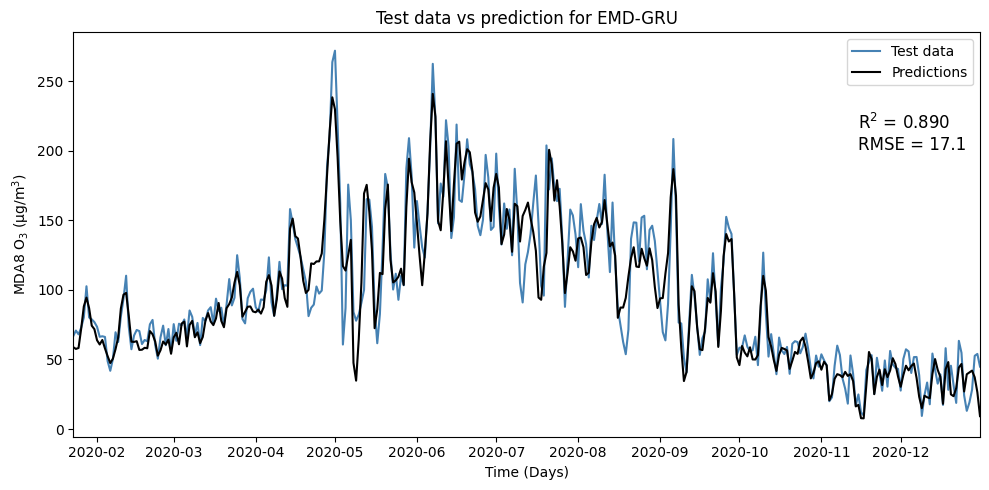

In [20]:
plot_vs_future_CI(y_test_simple_new, "EMD-GRU",final)